In [1]:
from copy import deepcopy
from itertools import product
import pandas as pd
import networkx as nx

import pm4py

In [2]:
dcr_source = {
    'events': set(['A','B','C','D','E','F']),
    'conditionsFor': {'A':{'B'},'C':{'B'}},
    'milestonesFor': {},
    'responseTo': {},
    'noResponseTo': {},
    'includesTo': {'A':{'D','E','F'},'B':{'D','E','F'}},
    'excludesTo': {'C':{'D','E','F'}},
    'marking': {'executed': set(),
                'included': set(['A','B','C','D','E','F']),
                'pending': set(),
                'executedTime': {},  # Gives the time since a event was executed
                'pendingDeadline': {}  # The deadline until an event must be executed
                },
    'conditionsForDelays': {},
    'responseToDeadlines': {},
    'subprocesses': {},
    'nestings': {},
    'labels': set(),
    'labelMapping': {},
    'roles': set(),
    'roleAssignments': {},
    'readRoleAssignments': {}
}

dcr = deepcopy(dcr_source)

# For CAISE 2023 - Nesting, patterns, choices, simplicity

In [11]:
def common_out_neighbors(g, i, j):
    return set(g.successors(i)).intersection(g.successors(j))

def common_in_neighbors(g, i, j):
    return set(g.predecessors(i)).intersection(g.predecessors(j))

In [12]:
all_rels = ['conditionsFor', 'responseTo', 'includesTo', 'excludesTo', 'milestonesFor','noResponseTo']

def build_rel_matrix(dcr):
    mat_keys = product(dcr['events'],set(all_rels))
    ind = pd.MultiIndex.from_tuples(sorted(mat_keys))
    rel_matrix = pd.DataFrame(0,columns=ind,index=ind,dtype=int)
    for rel in ['conditionsFor', 'responseTo', 'includesTo', 'excludesTo', 'milestonesFor','noResponseTo']:
        for e in dcr['events']:
            for e_prime in dcr['events']:
                if e in dcr[rel] and e_prime in dcr[rel][e]:
                    rel_matrix.at[(e,rel),(e_prime,rel)] = 1

    return rel_matrix
# for all relations get pairs of nodes that share at least a common successor or predecessor in this adjencency graph
def find_nestings(events, rel_matrix):
    nestings = {}
    nestings_events = {}
    relations_to_remove = {}
    new_events = set()
    relations_to_add = {}
    
    i = 0
    new_nestings_found = True
    G = nx.from_pandas_adjacency(rel_matrix,create_using=nx.DiGraph)
    
    while new_nestings_found:
        new_arrows = set()
        new_nodes = set()
        arrows_to_remove = set()
        largest_nesting = {}
        for e in events:
            for rel in all_rels:
                largest_nesting[(e,rel)] = 0
        for e in G.nodes:
            for e_prime in G.nodes:
                if e!=e_prime:
                    cin = common_in_neighbors(G,e,e_prime)
                    cin.discard(e)
                    cin.discard(e_prime)
                    con = common_out_neighbors(G,e,e_prime)
                    con.discard(e)
                    con.discard(e_prime)
                    if len(cin) > 0 or len(con) > 0:
                        if len(cin)>0:
                            for c in cin:
                                largest_nesting[c] += 1
                        if len(con)>0:
                            for c in con:
                                largest_nesting[c] += 1
        if max(largest_nesting.values())>0:
            e = max(largest_nesting, key=largest_nesting.get)
            suc_e = set(G.successors(e))
            suc_ee = set([e[0] for e in suc_e])
            pred_e = set(G.predecessors(e))
            pred_ee = set([e[0] for e in pred_e])
            if len(suc_e)>1:
                add = True
                for nk, nesting in nestings_events.items():
                    if nesting==suc_ee:
                        add = False
                if add:
                    nestings[f'N{i}'] = suc_e
                    nestings_events[f'N{i}'] = suc_ee
                    new_events.add(f'N{i}')
                    new_nodes.add(f'N{i}')
                    new_arrows.add((e, f'N{i}'))
                for s in suc_e:
                    arrows_to_remove.add((e, s))
                i += 1
            if len(pred_e)>1:
                add = True
                for nk, nesting in nestings_events.items():
                    if nesting==pred_ee:
                        add = False
                if add:
                    nestings[f'N{i}'] = pred_e
                    nestings_events[f'N{i}'] = pred_ee
                    new_events.add(f'N{i}')
                    new_nodes.add(f'N{i}')
                    new_arrows.add((f'N{i}',e))
                for p in pred_e:
                    arrows_to_remove.add((p, e))
                i += 1

            relations_to_remove.update(arrows_to_remove)
            relations_to_add.update(new_arrows)
            for k,v in arrows_to_remove:
                G.remove_edge(k,v)
            for k in new_nodes:
                G.add_node(k)
            for k,v in new_arrows:
                G.add_edge(k,v)
        else:
            new_nestings_found = False
    
    return nestings_events, new_events, relations_to_remove, relations_to_add

rel_mat = build_rel_matrix(dcr)

In [13]:
rel_mat

A                                      \
                conditionsFor excludesTo includesTo milestonesFor   
A conditionsFor             0          0          0             0   
  excludesTo                0          0          0             0   
  includesTo                0          0          0             0   
  milestonesFor             0          0          0             0   
  noResponseTo              0          0          0             0   
  responseTo                0          0          0             0   
B conditionsFor             0          0          0             0   
  excludesTo                0          0          0             0   
  includesTo                0          0          0             0   
  milestonesFor             0          0          0             0   
  noResponseTo              0          0          0             0   
  responseTo                0          0          0             0   
C conditionsFor             0          0          0             0   
  excludesTo                0          0          0             0   
  includesTo                0          0          0             0   
  milestonesFor             0          0          0             0   
  noResponseTo              0          0          0             0   
  responseTo                0          0          0             0   
D conditionsFor             0          0          0             0   
  excludesTo                0          0          0             0   
  includesTo                0          0          0             0   
  milestonesFor             0          0          0             0   
  noResponseTo              0          0          0             0   
  responseTo                0          0          0             0   
E conditionsFor             0          0          0             0   
  excludesTo                0          0          0             0   
  includesTo                0          0          0             0   
  milestonesFor             0          0          0             0   
  noResponseTo              0          0          0             0   
  responseTo                0          0          0             0   
F conditionsFor             0          0          0             0   
  excludesTo                0          0          0             0   
  includesTo                0          0          0             0   
  milestonesFor             0          0          0             0   
  noResponseTo              0          0          0             0   
  responseTo                0          0          0             0   

                                                    B                        \
                noResponseTo responseTo conditionsFor excludesTo includesTo   
A conditionsFor            0          0             1          0          0   
  excludesTo               0          0             0          0          0   
  includesTo               0          0             0          0          0   
  milestonesFor            0          0             0          0          0   
  noResponseTo             0          0             0          0          0   
  responseTo               0          0             0          0          0   
B conditionsFor            0          0             0          0          0   
  excludesTo               0          0             0          0          0   
  includesTo               0          0             0          0          0   
  milestonesFor            0          0             0          0          0   
  noResponseTo             0          0             0          0          0   
  responseTo               0          0             0          0          0   
C conditionsFor            0          0             1          0          0   
  excludesTo               0          0             0          0          0   
  includesTo               0          0             0          0          0   
  milestonesFor            0          0             0         

In [14]:
G = nx.from_pandas_adjacency(rel_mat,create_using=nx.DiGraph)

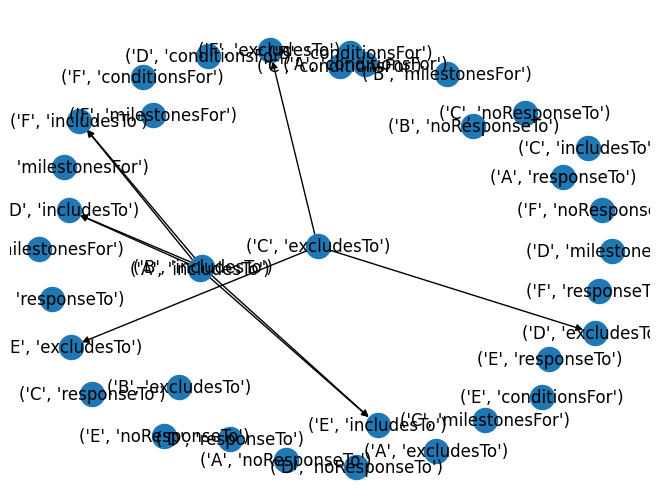

In [16]:
nx.draw(G,with_labels=True)

In [20]:
find_nestings(dcr['events'],)

({'N0': {'D', 'E', 'F'}, 'N3': {'A', 'C'}},
 {'N0', 'N3'},
 {('B', 'includesTo'): ('D', 'includesTo'),
  ('C', 'excludesTo'): ('E', 'excludesTo'),
  ('A', 'includesTo'): ('E', 'includesTo'),
  ('A', 'conditionsFor'): ('B', 'conditionsFor'),
  ('C', 'conditionsFor'): ('B', 'conditionsFor')},
 {('B', 'includesTo'): 'N0', 'N3': ('B', 'conditionsFor')})

In [45]:
all_rels = ['conditionsFor', 'responseTo', 'includesTo', 'excludesTo', 'milestonesFor','noResponseTo']

def build_rel_matrix_v2(dcr):
    mat_keys = product(dcr['events'],set(all_rels))
    ind = pd.MultiIndex.from_tuples(sorted(mat_keys))
    rel_matrix = pd.DataFrame(0,columns=ind,index=ind,dtype=int)
    for rel in all_rels:
        for e in dcr['events']:
            for e_prime in dcr['events']:
                if e in dcr[rel] and e_prime in dcr[rel][e]:
                    if rel in ['conditionsFor', 'milestonesFor']:
                        rel_matrix.at[(e_prime,rel),(e,rel)] = 1
                    else:
                        rel_matrix.at[(e,rel),(e_prime,rel)] = 1

    return rel_matrix

# for all relations get pairs of nodes that share at least a common successor or predecessor in this adjencency graph
def find_nestings_v2(events, rel_matrix):
    nestings = {}
    nestings_events = {}
    relations_to_remove = {}
    new_events = set()
    relations_to_add = {}
    
    i = 0
    new_nestings_found = True
    G = nx.from_pandas_adjacency(rel_matrix,create_using=nx.DiGraph)
    
    while new_nestings_found:
        new_arrows = set()
        new_nodes = set()
        arrows_to_remove = set()
        largest_nesting = {}
        for e in events:
            for rel in all_rels:
                largest_nesting[(e,rel)] = 0
        for e in G.nodes:
            for e_prime in G.nodes:
                if e!=e_prime:
                    cin = common_in_neighbors(G,e,e_prime)
                    # cin.discard(e)
                    # cin.discard(e_prime)
                    con = common_out_neighbors(G,e,e_prime)
                    # con.discard(e)
                    # con.discard(e_prime)
                    if len(cin) > 0 or len(con) > 0:
                        if len(cin)>0:
                            for c in cin:
                                largest_nesting[c] += 1
                        if len(con)>0:
                            for c in con:
                                largest_nesting[c] += 1
        if max(largest_nesting.values())>0:
            e = max(largest_nesting, key=largest_nesting.get)
            suc_e = set(G.successors(e))
            suc_ee = set([e[0] for e in suc_e])
            pred_e = set(G.predecessors(e))
            pred_ee = set([e[0] for e in pred_e])
            if len(suc_e)>=1:
                add = True
                for nk, nesting in nestings_events.items():
                    if nesting==suc_ee:
                        add = False
                if add:
                    nestings[f'N{i}'] = suc_e
                    nestings_events[f'N{i}'] = suc_ee
                    new_events.add(f'N{i}')
                    new_nodes.add(f'N{i}')
                    new_arrows.add((e, f'N{i}'))
                for s in suc_e:
                    arrows_to_remove.add((e, s))
                i += 1
            if len(pred_e)>=1:
                add = True
                for nk, nesting in nestings_events.items():
                    if nesting==pred_ee:
                        add = False
                if add:
                    nestings[f'N{i}'] = pred_e
                    nestings_events[f'N{i}'] = pred_ee
                    new_events.add(f'N{i}')
                    new_nodes.add(f'N{i}')
                    new_arrows.add((f'N{i}',e))
                for p in pred_e:
                    arrows_to_remove.add((p, e))
                i += 1

            relations_to_remove.update(arrows_to_remove)
            relations_to_add.update(new_arrows)
            for k,v in arrows_to_remove:
                G.remove_edge(k,v)
            for k in new_nodes:
                G.add_node(k)
            for k,v in new_arrows:
                G.add_edge(k,v)
        else:
            new_nestings_found = False
    
    return nestings_events, new_events, relations_to_remove, relations_to_add

rel_mat_v2 = build_rel_matrix_v2(dcr)
find_nestings_v2(dcr['events'],rel_mat_v2)

({'N0': {'D', 'E', 'F'}, 'N3': {'A', 'C'}},
 {'N0', 'N3'},
 {('B', 'includesTo'): ('D', 'includesTo'),
  ('C', 'excludesTo'): ('E', 'excludesTo'),
  ('A', 'includesTo'): ('E', 'includesTo'),
  ('B', 'conditionsFor'): ('A', 'conditionsFor')},
 {('B', 'includesTo'): 'N0', ('B', 'conditionsFor'): 'N3'})

In [ ]:
from pm4py.algo.discovery.dcr_discover import algorithm
log = pm4py.read_xes('/home/vco/Projects/pm4py-dcr/datasets/rtfmp.xes',return_legacy_log_object=True)
rtfmp_reference_dcr, _ = algorithm.apply(log)
rtfmp_rel_matrix = build_rel_matrix(rtfmp_reference_dcr)

In [17]:
nestings_rtfmp, new_events, relations_to_remove, relations_to_add = find_nestings(rtfmp_reference_dcr, rtfmp_rel_matrix)
print(nestings_rtfmp)

NameError: name 'rtfmp_reference_dcr' is not defined

# F*** me

In [157]:
from pm4py.objects.dcr.obj import Relations

from itertools import chain, combinations


def find_groups(dcr):
    enc = {}

    def all_subsets(ss):
        return chain(*map(lambda x: combinations(ss, x), range(1, len(ss)+1)))
    
    for es in all_subsets(dcr['events']):
        enc[frozenset(es)] = {'pred': set(), 'succ': set()}
    for e in dcr['events']:
        for e_prime in dcr['events']:
            for r in Relations:
                if e in dcr[r.value] and e_prime in dcr[r.value][e]:
                    enc[frozenset([e])]['succ'].add((e_prime,r))
                    enc[frozenset([e_prime])]['pred'].add((e,r))
    for es, _ in enc.items():
        if len(es)>1:
            common_preds_list = []
            common_succs_list = []
            for e in es:
                key = frozenset(set(es).difference(set([e])))
                common_preds_list.append(enc[key]['pred'])
                common_succs_list.append(enc[key]['succ'])
            set_common_pred = set.intersection(*common_preds_list)
            set_common_succ = set.intersection(*common_succs_list)
            enc[es] = {'pred': set_common_pred, 'succ': set_common_succ}
    def get_set_from_tuple(tuple_set):
        res = set()
        for e, r in tuple_set:
            res.add(e)
        return res
    
    def is_already_there(es, cand, enc):
        if es.issubset(get_set_from_tuple(enc[cand]['pred'])) and get_set_from_tuple(enc[es]['succ']) == cand:
            return True
        elif es.issubset(get_set_from_tuple(enc[cand]['succ'])) and get_set_from_tuple(enc[es]['pred']) == cand:
            return True
        else:
            return False
    
    cands = set()
    for es in sorted(enc, key=len, reverse=True):
        # print(f'{es}: {enc[es]} \n\n')
        if len(es) > 1 and (len(enc[es]['pred']) > 0 or len(enc[es]['succ']) > 0):
            consider = True
            for cand in cands:
                if es.issubset(cand) and enc[es]['pred'] == enc[cand]['pred'] and enc[es]['pred'] == enc[cand]['pred']:
                    consider = False
                    break
            if consider:
                cands.add(es)
    for cand in cands:
        print(cand, enc[cand])
    return cands

In [158]:
bpic17_offer = {'events': {'O_Accepted',
  'O_Cancelled',
  'O_Create Offer',
  'O_Created',
  'O_Refused',
  'O_Returned',
  'O_Sent (mail and online)',
  'O_Sent (online only)'},
 'conditionsFor': {'O_Returned': {'O_Sent (mail and online)',
   'O_Sent (online only)'},
  'O_Accepted': {'O_Returned'},
  'O_Sent (online only)': {'O_Created'},
  'O_Sent (mail and online)': {'O_Created'},
  'O_Cancelled': {'O_Created'},
  'O_Created': {'O_Create Offer'},
  'O_Refused': {'O_Created'},
  'O_Create Offer': set()},
 'milestonesFor': {},
 'responseTo': {
  'O_Create Offer': {'O_Created'}},
 'noResponseTo': {},
 'includesTo': {},
 'excludesTo': {'O_Returned': {'O_Returned'},
  'O_Accepted': {'O_Accepted', 'O_Cancelled', 'O_Refused'},
  'O_Sent (online only)': {'O_Sent (mail and online)', 'O_Sent (online only)'},
  'O_Sent (mail and online)': {'O_Sent (mail and online)',
   'O_Sent (online only)'},
  'O_Cancelled': {'O_Accepted', 'O_Cancelled', 'O_Refused'},
  'O_Created': {'O_Created'},
  'O_Refused': {'O_Accepted', 'O_Cancelled', 'O_Refused'},
  'O_Create Offer': {'O_Create Offer'}},
 'marking': {'executed': set(),
  'included': {'O_Accepted',
   'O_Cancelled',
   'O_Create Offer',
   'O_Created',
   'O_Refused',
   'O_Returned',
   'O_Sent (mail and online)',
   'O_Sent (online only)'},
  'pending': set(),
  'executedTime': {},
  'pendingDeadline': {}},
 'conditionsForDelays': {},
 'responseToDeadlines': {},
 'subprocesses': {},
 'nestings': {},
 'nestingsMap': {},
 'labels': set(),
 'labelMapping': {},
 'roles': set(),
 'roleAssignments': {},
 'readRoleAssignments': {}}

In [159]:
res = find_groups(bpic17_offer)
print('[i] cands: ---------------------------- \n')
for r in res:
    print(f'{r}\n')

frozenset({'O_Refused', 'O_Sent (online only)', 'O_Cancelled', 'O_Sent (mail and online)'}) {'pred': set(), 'succ': {('O_Created', <Relations.C: 'conditionsFor'>)}}
frozenset({'O_Refused', 'O_Accepted', 'O_Cancelled'}) {'pred': {('O_Cancelled', <Relations.E: 'excludesTo'>), ('O_Accepted', <Relations.E: 'excludesTo'>), ('O_Refused', <Relations.E: 'excludesTo'>)}, 'succ': {('O_Cancelled', <Relations.E: 'excludesTo'>), ('O_Accepted', <Relations.E: 'excludesTo'>), ('O_Refused', <Relations.E: 'excludesTo'>)}}
frozenset({'O_Sent (online only)', 'O_Sent (mail and online)'}) {'pred': {('O_Sent (mail and online)', <Relations.E: 'excludesTo'>), ('O_Returned', <Relations.C: 'conditionsFor'>), ('O_Sent (online only)', <Relations.E: 'excludesTo'>)}, 'succ': {('O_Sent (online only)', <Relations.E: 'excludesTo'>), ('O_Sent (mail and online)', <Relations.E: 'excludesTo'>), ('O_Created', <Relations.C: 'conditionsFor'>)}}
[i] cands: ---------------------------- 

frozenset({'O_Refused', 'O_Sent (online 